In [2]:
import timm
for m in timm.list_models(pretrained=True):
    print(m)

bat_resnext26ts.ch_in1k
beit_base_patch16_224.in22k_ft_in22k
beit_base_patch16_224.in22k_ft_in22k_in1k
beit_base_patch16_384.in22k_ft_in22k_in1k
beit_large_patch16_224.in22k_ft_in22k
beit_large_patch16_224.in22k_ft_in22k_in1k
beit_large_patch16_384.in22k_ft_in22k_in1k
beit_large_patch16_512.in22k_ft_in22k_in1k
beitv2_base_patch16_224.in1k_ft_in1k
beitv2_base_patch16_224.in1k_ft_in22k
beitv2_base_patch16_224.in1k_ft_in22k_in1k
beitv2_large_patch16_224.in1k_ft_in1k
beitv2_large_patch16_224.in1k_ft_in22k
beitv2_large_patch16_224.in1k_ft_in22k_in1k
botnet26t_256.c1_in1k
caformer_b36.sail_in1k
caformer_b36.sail_in1k_384
caformer_b36.sail_in22k
caformer_b36.sail_in22k_ft_in1k
caformer_b36.sail_in22k_ft_in1k_384
caformer_m36.sail_in1k
caformer_m36.sail_in1k_384
caformer_m36.sail_in22k
caformer_m36.sail_in22k_ft_in1k
caformer_m36.sail_in22k_ft_in1k_384
caformer_s18.sail_in1k
caformer_s18.sail_in1k_384
caformer_s18.sail_in22k
caformer_s18.sail_in22k_ft_in1k
caformer_s18.sail_in22k_ft_in1k_384
c

In [4]:
import glob
import numpy as np
from pathlib import Path
import shutil

def create_pcb_train_val_test(data_dir='PCBData',
                              train_dir='PCBData/train',
                              val_dir='PCBData/val',
                              test_dir='PCBData/test'
                             ):
    #all_files = glob.glob(data_dir+'/@(NG|OK)/*.jpg', flags=pathlib.GLOBSTAR | pathlib.EXTGLOB)
    ng_files = sorted(glob.glob(data_dir+"/NG/*.jpg"))
    n_ng = len(ng_files)
    ok_files = sorted(glob.glob(data_dir+"/OK/*.jpg"))
    n_ok = len(ok_files)
    #creating a new directory called pythondirectory
    Path(train_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(train_dir+'/NG').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/NG').mkdir(parents=True, exist_ok=True)
    np.random.seed(42)
    perm = np.random.permutation(n_ng)
    n_val = int(n_ng*0.1)//4*4
    n_train = n_ng - n_val
    src_files = ng_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
    perm = np.random.permutation(n_ok)
    n_val = int(n_ok*0.1)*4//4
    n_train = n_ok - n_val
    src_files = ok_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
#create_pcb_train_val_test()

In [2]:
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

In [10]:
callbacks = list(DEFAULT_CALLBACKS)
callbacks.pop(3)

[pytorch_accelerated.callbacks.MoveModulesToDeviceCallback,
 pytorch_accelerated.callbacks.TerminateOnNaNCallback,
 pytorch_accelerated.callbacks.PrintProgressCallback,
 pytorch_accelerated.callbacks.LogMetricsCallback,
 0]

In [1]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

from pytorch_accelerated.callbacks import SaveBestModelCallback, ProgressBarCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS
from pytorch_accelerated.run_config import TrainerRunConfig
from pytorch_accelerated.utils import local_process_zero_only

from PIL import Image

from tqdm.auto import tqdm
import time
import pandas as pd

from accelerate import notebook_launcher
import accelerate

class TQDM_progressbar(ProgressBarCallback):
    """
    A callback which visualises the state of each training and evaluation epoch using a progress bar
    """

    def __init__(self):
        self.pbar = None

    def on_train_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._train_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_train_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_train_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

    def on_eval_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._eval_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_eval_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_eval_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

class ImageDataset_new(timm.data.dataset.ImageDataset):
    def __init__(
            self,
            root,
            reader=None,
            split='train',
            class_map=None,
            load_bytes=False,
            input_img_mode='RGB',
            transform=None,
            target_transform=None,
    ):
        super().__init__(root, reader, split, class_map, load_bytes, input_img_mode, transform, target_transform)
        
    def __getitem__(self, index):
        img, target = self.reader[index]

        '''
        try:
            img = img.read() if self.load_bytes else Image.open(img)
        except Exception as e:
            _logger.warning(f'Skipped sample (index {index}, file {self.reader.filename(index)}). {str(e)}')
            self._consecutive_errors += 1
            if self._consecutive_errors < _ERROR_RETRY:
                return self.__getitem__((index + 1) % len(self.reader))
            else:
                raise e
        '''
        self._consecutive_errors = 0

        with Image.open(img) as im:
            if self.input_img_mode and not self.load_bytes:
                img = im.convert(self.input_img_mode)
            
        if self.transform is not None:
            img = self.transform(img)

        if target is None:
            target = -1
        elif self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),  # 좌우반전 
            #RotateTransform([0,90,180,270]),
            #transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    from torchvision import datasets
    train_dataset = datasets.ImageFolder(train_path, train_transforms)
    eval_dataset = datasets.ImageFolder(val_path, eval_transforms)

    return train_dataset, eval_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        #self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        #mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        #return super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        return super().calculate_train_batch_loss((xb, yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

        # learning rate log
        self.run_history.update_metric("lr", self.optimizer.param_groups[0]['lr'])

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            if self.ema_model is not None:
                ema_model_preds = self.ema_model.module(xb).argmax(-1)
                self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

data_path='PCBData'
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
#lr = 5e-3
lr = 0.0002
smoothing = 0.1
mixup = 0.2
cutmix = 1.0
batch_size = 64
bce_target_thresh = 0.2
num_epochs = 40

data_path = Path(data_path)
train_path = data_path / "train"
val_path = data_path / "val"

num_classes = len(list(train_path.iterdir()))

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)

# Create model using timm
model = timm.create_model(
    "resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"efficientnet_b4.ra2_in1k", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"efficientvit_b3.r224_in1k", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_clip_224.openai", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_224", pretrained=True, num_classes=num_classes
)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create training and validation datasets
train_dataset, eval_dataset = create_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

def my_train():
    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    train_loss_fn = timm.loss.BinaryCrossEntropy(
        target_threshold=bce_target_thresh, smoothing=smoothing
    )
    validate_loss_fn = torch.nn.CrossEntropyLoss()

    default_callbacks = list(DEFAULT_CALLBACKS)
    default_callbacks.pop(3)

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            #*DEFAULT_CALLBACKS,
            *default_callbacks,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            TQDM_progressbar,
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )
    
    @local_process_zero_only
    def save_history():
        #print(trainer.run_history.get_metric_names())
        train_loss_epoch = trainer.run_history.get_metric_values('train_loss_epoch')
        eval_loss_epoch = trainer.run_history.get_metric_values('eval_loss_epoch')
        accuracy = trainer.run_history.get_metric_values('accuracy')
        accuracy = [acc.numpy() for acc in accuracy]
        lr = trainer.run_history.get_metric_values('lr')
        df = pd.DataFrame(data={'train_loss': train_loss_epoch,
                                'val_loss': eval_loss_epoch,
                                'val_acc': accuracy,
                                'lr': lr,
                               })
        df.to_csv('train_history.csv', index=False)
        #print(trainer.scheduler._get_lr())

    save_history()
    
    #trainer.evaluate(
    #    per_device_batch_size=batch_size,
    #    dataset=eval_dataset,
    #)

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    #args = parser.parse_args(args=['--data_dir=imagenette2-320'])
    args = parser.parse_args(args=['--data_dir=PCBData'])
    main(args.data_dir)
'''

notebook_launcher(my_train, num_processes=4)
#my_train()

Launching training on 4 GPUs.


/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 64 with the eval dataset size 1272 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 64 with the eval dataset size 1272 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per d


Starting training run

Starting epoch 1


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.41591885685920715


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.3396022617816925

ema_model_accuracy: 0.3977987468242645

accuracy: 0.8128930926322937

lr: 0.0001

Starting epoch 2


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.20825928449630737


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.1566144824028015

ema_model_accuracy: 0.42767295241355896

accuracy: 0.946540892124176

lr: 0.0001666666666666667

Starting epoch 3


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.13980498909950256


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.1460920125246048

ema_model_accuracy: 0.402515709400177

accuracy: 0.955974817276001

lr: 0.00019725080707956884

Starting epoch 4


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.12012369185686111


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.14749716222286224

ema_model_accuracy: 0.37735849618911743

accuracy: 0.9567610025405884

lr: 0.0001951301233713678

Starting epoch 5


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.10110285133123398


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.1439540535211563

ema_model_accuracy: 0.3537735939025879

accuracy: 0.9575471878051758

lr: 0.00019242601348487304

Starting epoch 6


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.0914723202586174


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.16043658554553986

ema_model_accuracy: 0.32468554377555847

accuracy: 0.9606918096542358

lr: 0.0001891551491567426

Starting epoch 7


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.08280465006828308


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.19050736725330353

ema_model_accuracy: 0.29559749364852905

accuracy: 0.9567610025405884

lr: 0.00018533769635323217

Starting epoch 8


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.07027780264616013


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.18017064034938812

ema_model_accuracy: 0.2916666567325592

accuracy: 0.9567610025405884

lr: 0.00018099719094030728

Starting epoch 9


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.061315715312957764


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.21230047941207886

ema_model_accuracy: 0.2845911979675293

accuracy: 0.948113203048706

lr: 0.0001761603935772031

Starting epoch 10


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.05521057918667793


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.22641591727733612

ema_model_accuracy: 0.2845911979675293

accuracy: 0.9583333134651184

lr: 0.0001708571247280615

Starting epoch 11


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.04821225255727768


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.2689577341079712

ema_model_accuracy: 0.29638364911079407

accuracy: 0.9473270177841187

lr: 0.0001651200808088533

Starting epoch 12


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.04294995963573456


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.28226935863494873

ema_model_accuracy: 0.3128930926322937

accuracy: 0.9551886916160583

lr: 0.0001589846326031011

Starting epoch 13


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.034219514578580856


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.2684597373008728

ema_model_accuracy: 0.3317610025405884

accuracy: 0.9520440101623535

lr: 0.0001524886071892369

Starting epoch 14


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.03196138143539429


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.30050864815711975

ema_model_accuracy: 0.35927674174308777

accuracy: 0.9567610025405884

lr: 0.00014567205472408492

Starting epoch 15


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.030980894342064857


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.31139734387397766

ema_model_accuracy: 0.37893080711364746

accuracy: 0.9567610025405884

lr: 0.00013857700152032645

Starting epoch 16


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.026495393365621567


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.32954689860343933

ema_model_accuracy: 0.40015724301338196

accuracy: 0.9536163806915283

lr: 0.00013124719094030727

Starting epoch 17


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.019051549956202507


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.3423965275287628

ema_model_accuracy: 0.4229559600353241

accuracy: 0.9551886916160583

lr: 0.0001237278137036626

Starting epoch 18


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.01856391876935959


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.35981935262680054

ema_model_accuracy: 0.44889935851097107

accuracy: 0.9575471878051758

lr: 0.00011606522927150298

Starting epoch 19


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.01771230250597


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.347040057182312

ema_model_accuracy: 0.48427674174308777

accuracy: 0.9591194987297058

lr: 0.00010830668002492059

Starting epoch 20


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.017587365582585335


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.3386410176753998

ema_model_accuracy: 0.5227987170219421

accuracy: 0.9575471878051758

lr: 0.0001005

Starting epoch 21


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.01359754428267479


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.37521812319755554

ema_model_accuracy: 0.5628930926322937

accuracy: 0.9599056839942932

lr: 9.269331997507945e-05

Starting epoch 22


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.01276219729334116


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.402511328458786

ema_model_accuracy: 0.6092767119407654

accuracy: 0.9575471878051758

lr: 8.493477072849705e-05

Starting epoch 23


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.010393631644546986


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4120114743709564

ema_model_accuracy: 0.6493710875511169

accuracy: 0.955974817276001

lr: 7.727218629633742e-05

Starting epoch 24


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.009560085833072662


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4378206133842468

ema_model_accuracy: 0.6847484111785889

accuracy: 0.9583333134651184

lr: 6.975280905969274e-05

Starting epoch 25


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.009541893377900124


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.45805007219314575

ema_model_accuracy: 0.7193396091461182

accuracy: 0.9551886916160583

lr: 6.242299847967357e-05

Starting epoch 26


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.009602377191185951


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.46160024404525757

ema_model_accuracy: 0.7610062956809998

accuracy: 0.9575471878051758

lr: 5.53279452759151e-05

Starting epoch 27


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.008438953198492527


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4778273403644562

ema_model_accuracy: 0.8003144860267639

accuracy: 0.9583333134651184

lr: 4.8511392810763094e-05

Starting epoch 28


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.009893287904560566


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.45191851258277893

ema_model_accuracy: 0.8317610025405884

accuracy: 0.9606918096542358

lr: 4.201536739689893e-05

Starting epoch 29


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.008837207220494747


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4527530372142792

ema_model_accuracy: 0.8655660152435303

accuracy: 0.9583333134651184

lr: 3.5879919191146734e-05

Starting epoch 30


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.007704786956310272


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.44966384768486023

ema_model_accuracy: 0.8805031180381775

accuracy: 0.9599056839942932

lr: 3.014287527193853e-05

Starting epoch 31


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.00727001903578639


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4524386525154114

ema_model_accuracy: 0.902515709400177

accuracy: 0.9575471878051758

lr: 2.4839606422796924e-05

Starting epoch 32


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.007152581121772528


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4521430730819702

ema_model_accuracy: 0.9158805012702942

accuracy: 0.9575471878051758

lr: 2.0002809059692742e-05

Starting epoch 33


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.006454645190387964


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.46211665868759155

ema_model_accuracy: 0.9198113083839417

accuracy: 0.955974817276001

lr: 1.566230364676783e-05

Starting epoch 34


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.006812830921262503


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.44876185059547424

ema_model_accuracy: 0.9245283007621765

accuracy: 0.9575471878051758

lr: 1.1844850843257407e-05

Starting epoch 35


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.007587410509586334


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4560931622982025

ema_model_accuracy: 0.9331761002540588

accuracy: 0.9575471878051758

lr: 8.573986515126971e-06

Starting epoch 36


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.005640434101223946


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4563872218132019

ema_model_accuracy: 0.9331761002540588

accuracy: 0.955974817276001

lr: 5.8698766286322235e-06

Starting epoch 37


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.007150285877287388


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.46143239736557007

ema_model_accuracy: 0.930031418800354

accuracy: 0.955974817276001

lr: 3.7491929204311823e-06

Starting epoch 38


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.0070261419750750065


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.46574172377586365

ema_model_accuracy: 0.9339622855186462

accuracy: 0.9551886916160583

lr: 2.225010110783803e-06

Starting epoch 39


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.004743554629385471


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4610203802585602

ema_model_accuracy: 0.9347484111785889

accuracy: 0.9551886916160583

lr: 1.3067252935537676e-06

Starting epoch 40


  0%|          | 0/45 [00:00<?, ?it/s]


train_loss_epoch: 0.006508033722639084


  0%|          | 0/5 [00:00<?, ?it/s]


eval_loss_epoch: 0.4619902968406677

ema_model_accuracy: 0.9339622855186462

accuracy: 0.9551886916160583

lr: 1e-06
Finishing training run
Loading checkpoint with accuracy: 0.9606918096542358 from epoch 6


In [2]:
!cp train_history.csv train_history_res.csv
!cp best_model.pt best_model_res.pt

In [3]:
df = pd.read_csv('train_history_res.csv')
df

train_loss  val_loss   val_acc        lr
0     0.412593  0.342422  0.806604  0.000100
1     0.203958  0.177466  0.946541  0.000167
2     0.119128  0.192360  0.949685  0.000197
3     0.070155  0.233150  0.953616  0.000195
4     0.041551  0.339127  0.944182  0.000192
5     0.033342  0.338731  0.952830  0.000189
6     0.022875  0.403782  0.948113  0.000185
7     0.019280  0.411812  0.947327  0.000181
8     0.017401  0.409542  0.945755  0.000176
9     0.014111  0.467243  0.947327  0.000171
10    0.015697  0.504889  0.945755  0.000165
11    0.010190  0.496502  0.948113  0.000159
12    0.008821  0.539447  0.951258  0.000152
13    0.009919  0.571580  0.946541  0.000146
14    0.007957  0.543018  0.949685  0.000139
15    0.009046  0.574688  0.942610  0.000131
16    0.006357  0.562089  0.944969  0.000124
17    0.004990  0.574374  0.945755  0.000116
18    0.004722  0.608492  0.947327  0.000108
19    0.005866  0.591023  0.950472  0.000101
20    0.004802  0.568746  0.952044  0.000093
21    0.004826  0.519803  0.954403  0.000085
22    0.004021  0.606146  0.947327  0.000077
23    0.003008  0.602133  0.949685  0.000070
24    0.003462  0.653070  0.945755  0.000062
25    0.003495  0.594042  0.948899  0.000055
26    0.004396  0.616917  0.946541  0.000049
27    0.004327  0.612240  0.952044  0.000042
28    0.003171  0.616951  0.948899  0.000036
29    0.002981  0.624587  0.947327  0.000030
30    0.003736  0.606758  0.951258  0.000025
31    0.002739  0.602747  0.952044  0.000020
32    0.003317  0.617803  0.951258  0.000016
33    0.003003  0.596415  0.950472  0.000012
34    0.003654  0.602190  0.949685  0.000009
35    0.002519  0.604806  0.952830  0.000006
36    0.004425  0.598858  0.951258  0.000004
37    0.003640  0.606440  0.952044  0.000002
38    0.002092  0.602878  0.951258  0.000001
39    0.003129  0.615432  0.950472  0.000001

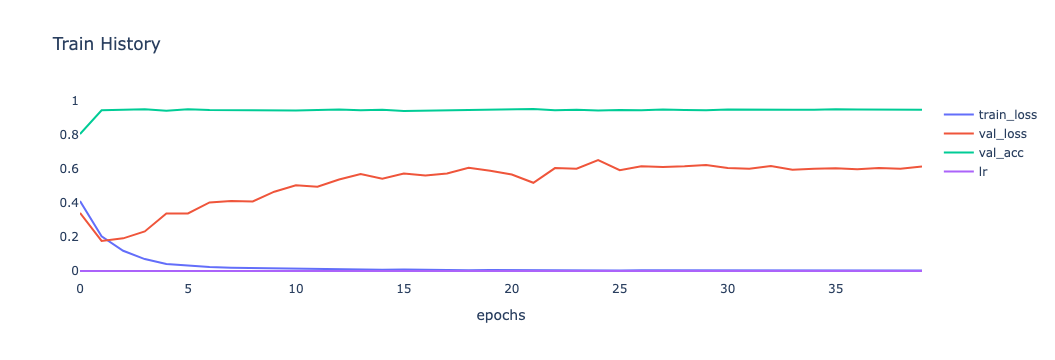

In [4]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot



data = [go.Scatter(x=df.index,
                   y=df[col],
                   name=col) for col in df.columns]

layout = go.Layout(
    plot_bgcolor="white",
    title='Train History',
    xaxis=dict(title='epochs')
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [2]:
import timm
import timm.optim
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()
eval_trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    callbacks=[
        *DEFAULT_CALLBACKS,
        #TQDM_progressbar,
    ],
)
eval_trainer.load_checkpoint('best_model.pt', load_optimizer=False)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=eval_dataset,
      )


Starting evaluation run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.19it/s]/home/kotech/venv-lightning/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.03it/s]



evaluation_loss: 0.1596289426088333

ema_model_accuracy: 0.0

accuracy: 0.9599056839942932
Finishing evaluation run


https://github.com/huggingface/accelerate/blob/main/examples/cv_example.py

In [3]:
#model.load_state_dict(torch.load('best_model_res.pt')['model_state_dict'])
device = torch.device('cuda')
#model.to(device)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=64)
y_pred = []
y_true = []
for i, batch in enumerate(eval_dataloader):
    # We could avoid this line since we set the accelerator with `device_placement=True`.
    x, y = batch
    x = x.to(device)
    with torch.no_grad():
        outputs = model(x)
    predictions = outputs.argmax(dim=-1).to('cpu')
    y_pred.append(predictions)
    y_true.append(y)
    #print(predictions)
    #print(y)
    #predictions, references = accelerator.gather_for_metrics((predictions, batch["label"]))
    #accurate_preds = predictions == references
    #num_elems += accurate_preds.shape[0]
    #accurate += accurate_preds.long().sum()

In [4]:
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

In [5]:
# accuracy
acc = (y_true == y_pred).sum()/len(y_pred)
print('accuracy =', acc)

accuracy = 0.9599056603773585


accuracy_score: 0.9599056603773585
              precision    recall  f1-score   support

           0     0.9829    0.9664    0.9746      1012
           1     0.8773    0.9346    0.9050       260

    accuracy                         0.9599      1272
   macro avg     0.9301    0.9505    0.9398      1272
weighted avg     0.9613    0.9599    0.9604      1272



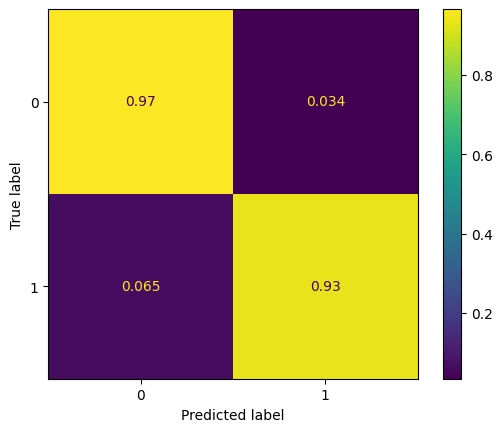

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print('accuracy_score:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
c = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [25]:
dataset = eval_dataset
n_data = len(dataset)
indices = np.array([i for i in range(n_data)])

In [35]:
print(n_data)
print(len(indices[(y_true==0)&(y_pred==1)]))
print(len(indices[(y_true==1)&(y_pred==0)]))
print(len(indices[y_true!=y_pred]))

1272
34
17
51


In [30]:
1221/1272

0.9599056603773585

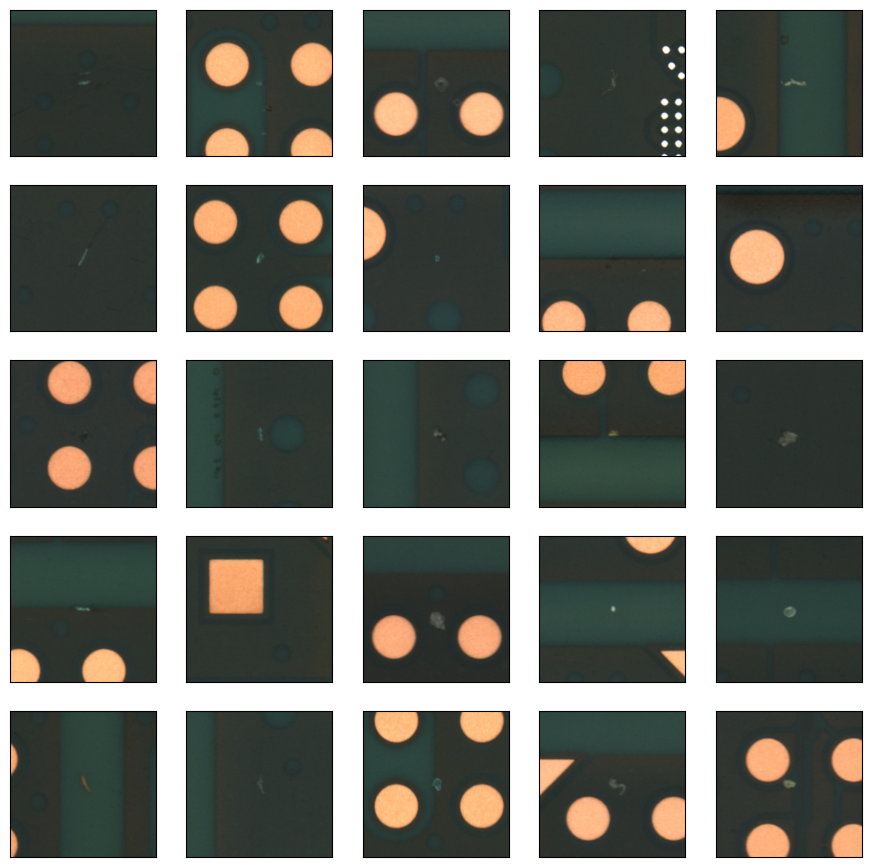

In [38]:
from matplotlib import image as mp_image
import numpy as np

plt.figure(figsize=(11,11))

indices_01 =indices[(y_true==0)&(y_pred==1)] 
perm = np.random.permutation(indices_01)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.imgs[idx][0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

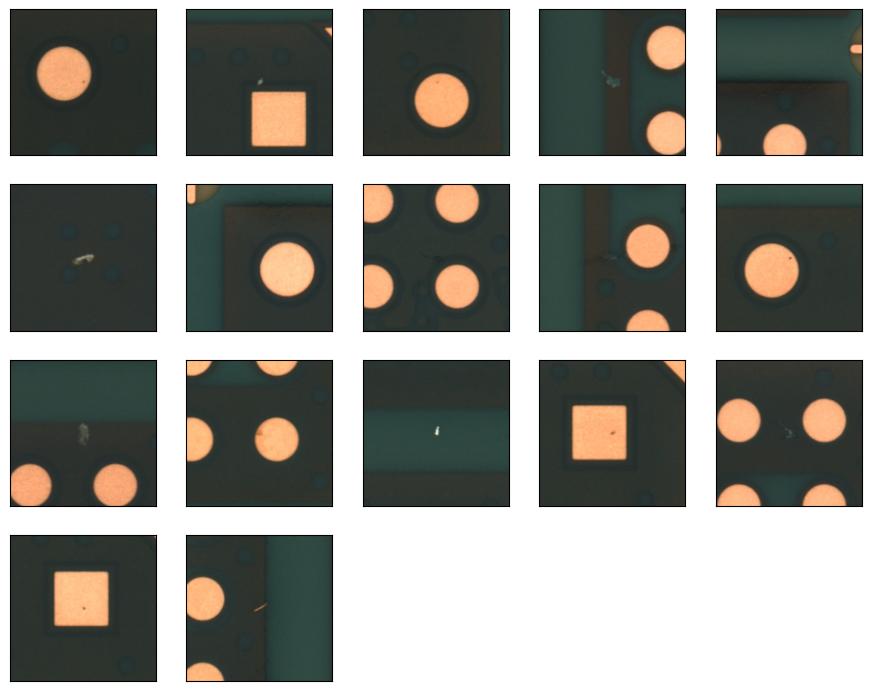

In [42]:
plt.figure(figsize=(11,11))

indices_10 =indices[(y_true==1)&(y_pred==0)] 
perm = np.random.permutation(indices_10)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.imgs[idx][0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

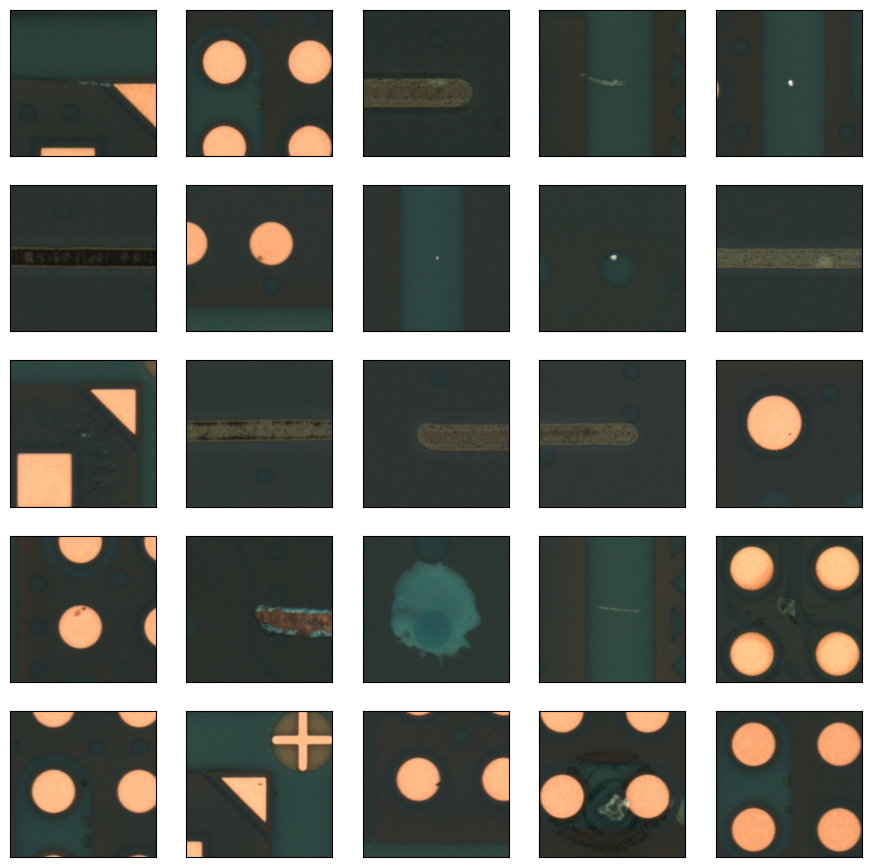

In [47]:
plt.figure(figsize=(11,11))

indices_00 =indices[(y_true==0)&(y_pred==0)] 
perm = np.random.permutation(indices_00)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.imgs[idx][0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

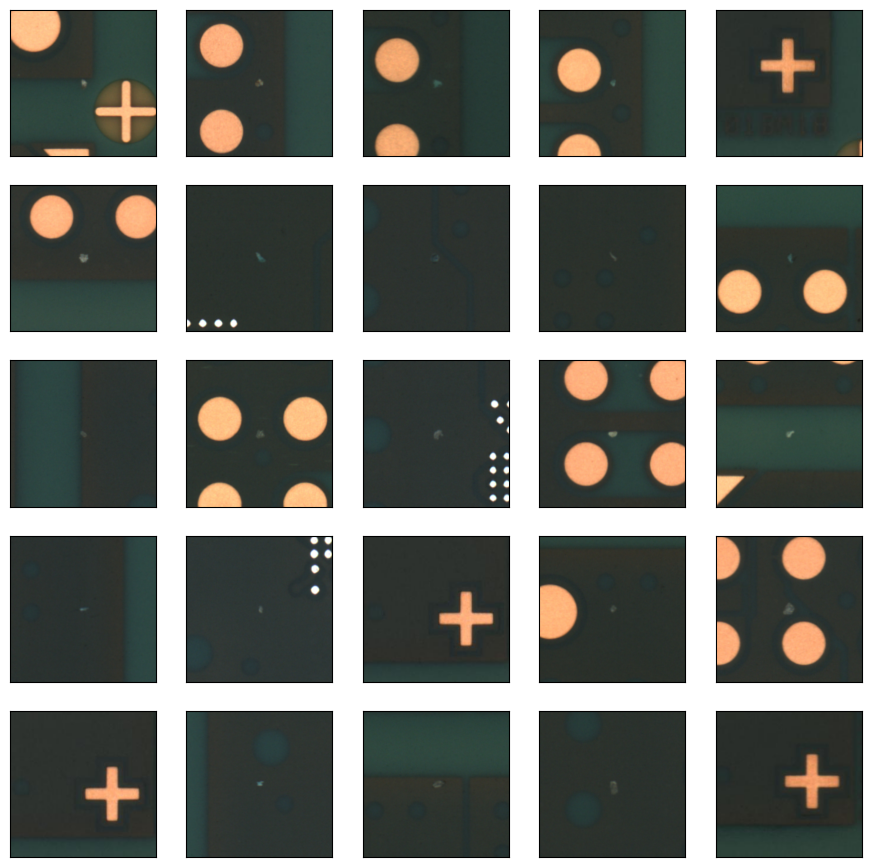

In [46]:
plt.figure(figsize=(11,11))

indices_11 =indices[(y_true==1)&(y_pred==1)] 
perm = np.random.permutation(indices_11)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.imgs[idx][0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()